In [258]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn

import warnings

warnings.filterwarnings("ignore")


class BayesianNetwork4Regression(nn.Module):
    """用于回归任务的贝叶斯全连接网络"""

    def __init__(self, prior_mu=0, prior_sigma=0.1,
                 in_features=1, hidden_features=250, out_features=1,
                 kl_weight=0.1, lr=0.01, weight_decay=0):
        super(BayesianNetwork4Regression, self).__init__()

        self.model = nn.Sequential(
            bnn.BayesLinear(prior_mu=prior_mu, prior_sigma=prior_sigma,
                            in_features=in_features, out_features=hidden_features),
            nn.ReLU(),
            bnn.BayesLinear(prior_mu=prior_mu, prior_sigma=prior_sigma,
                            in_features=hidden_features, out_features=out_features),
        ).double()

        self.kl_weight = kl_weight
        self.lr = lr
        self.weight_decay = weight_decay

        self.X_train, self.y_train = None, None
        self.X_numpy, self.y_numpy = None, None
        self.Xfit, self.yfit = None, None

    @staticmethod
    def _data_prepare(data):
        if isinstance(data, np.ndarray):
            data = torch.from_numpy(data)
        if len(data.size()) == 1:
            data = torch.unsqueeze(data, dim=1)
        return data.double()

    def _data_refresh(self, X, y):
        self.X_train, self.y_train = X, y
        self.X_numpy, self.y_numpy = X.data.numpy(), y.data.numpy()

    def fit(self, X, y, num_epochs=3000):
        X, y = self._data_prepare(data=X), self._data_prepare(data=y)
        self._data_refresh(X=X, y=y)
        print("X:", X.size(), "y:", y.size())
        mse_loss = nn.MSELoss()
        kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
        kl_weight = self.kl_weight
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr,
                               weight_decay=self.weight_decay)
        for _ in tqdm(range(num_epochs)):
            pre = self.model(X)
            mse = mse_loss(pre, y)
            kl = kl_loss(self.model)
            cost = mse + kl_weight * kl
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
        print('MSE : %2.5f, KL : %2.5f' % (mse.item(), kl.item()))

    def predict(self, Xfit):
        Xfit = self._data_prepare(data=Xfit)
        yfit = self.model(Xfit)
        self.Xfit = Xfit.data.numpy()
        self.yfit = yfit.data.numpy()
        return self.yfit

    def plotX(self, title='Bayesian Neural Network Regression', title_size=18,
              x_label='x', y_label='y', xy_size=15, figsize=(8, 5),
              color_scatter='royalblue', color_line='tomato', alpha=0.8, lw=2):
        fig, ax = plt.subplots(figsize=figsize)
        plt.style.use('seaborn-whitegrid')
        ax.scatter(self.X_numpy, self.y_numpy, color=color_scatter, alpha=alpha)
        ax.plot(self.Xfit, self.yfit, color=color_line, lw=lw)
        ax.set_title(title, fontsize=title_size)
        ax.set_xlabel(x_label, fontsize=xy_size)
        ax.set_ylabel(y_label, fontsize=xy_size)
        ax.legend(["Train Dataset", "BayesianRegression"], loc='best',
                  frameon=True, shadow=True, fontsize=xy_size - 2)
        for spine in ax.spines.values():
            spine.set_edgecolor("black")
            spine.set_linewidth(0.5)
        return fig

In [269]:
def fun(x):
    return np.sin(x) * 2 + np.cos(x) * 0.5 + np.random.randn(len(x)) * 0.35


x = np.random.rand(500) * 8
y = fun(x)

In [276]:
model = BayesianNetwork4Regression(lr=0.01, hidden_features=200)

model.fit(X=x, y=y, num_epochs=4000)

X: torch.Size([500, 1]) y: torch.Size([500, 1])


100%|██████████| 4000/4000 [00:08<00:00, 472.80it/s]

MSE : 0.23415, KL : 3.42428


In [277]:
xfit = np.linspace(0, 8, 3000)
yfit = model.predict(Xfit=xfit)

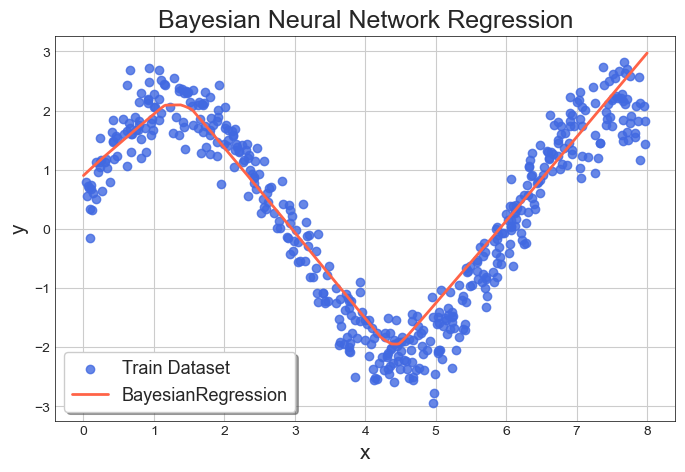

In [278]:
fig = model.plotX()

In [279]:
fig.savefig('贝叶斯网络回归.jpg', dpi=800, bbox_inches='tight')